In [2]:
"""
    Author : Olivier Leblanc - UCLouvain
    Date : 02/08/2021

    Code description :
    __________________
    Automatically write the mel filterbanks as arrays in c files.

"""
import os
from shutil import copyfile

import librosa  # For audio signal computations as MFCC
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal


def updir(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path


from classification.utils.utils import float2fixed

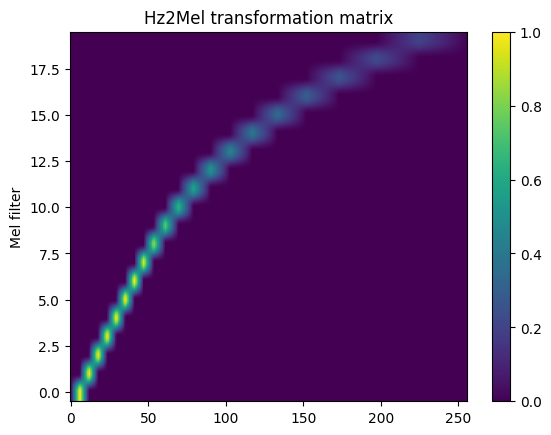

height = 20, width = 256


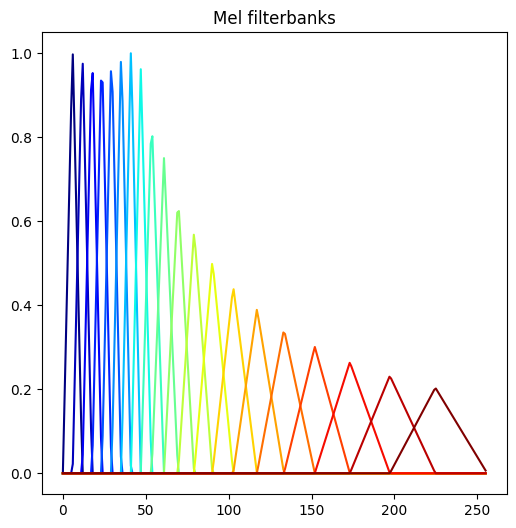

In [3]:
Nft = 512
# Nft=32
fs = 11025  # Hz
n_mels = 20

"Using librosa library"
plt.figure()
mel = librosa.filters.mel(sr=fs, n_fft=Nft, n_mels=n_mels)
mel = mel[:, :-1]
"Normalization"
mel = mel / np.max(mel)

plt.imshow(mel, aspect="auto", origin="lower")
plt.ylabel("Mel filter")
plt.colorbar()
plt.title("Hz2Mel transformation matrix")
plt.show()

H, W = mel.shape
print(f"height = {H}, width = {W}")

fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

colors = plt.cm.jet(np.linspace(0, 1, mel.shape[0]))
for line in range(mel.shape[0]):
    ax.plot(mel[line, :], color=colors[line])
#     # print(np.sum(np.abs(mel[line,:])!=0))
plt.title("Mel filterbanks")
plt.show()

## Signal format

In [4]:
"Option"
hardcoded_format = "q15"  #'q15'#'q31' #'float32'

mel_q15 = float2fixed(mel, 1)
mel_q31 = float2fixed(mel, 1, q=31)

# print(mel_q15[0,:10])
# print(mel_q31[0,:10])

if hardcoded_format == "q15":
    mel = mel_q15
    zero = str(0)
elif hardcoded_format == "q31":
    mel = mel_q31
    zero = str(0)
else:
    mel = mel
    zero = str(0.0)

## Open file and write content in it

In [12]:
# Declare array variable in header file
header = os.path.join(
    os.path.dirname(os.getcwd()), r"Embedded\UART_Printf\Inc\mel_fb.h"
)
fh = open(header, "a")
fh.truncate(0)  # Clear file content
fh.write('#include "sparse_math.h" \n')
fh.write("\n")
if hardcoded_format == "float32":
    fh.write(
        "extern sparse_matrix_instance_f32 mel_fb_spmat;  /* Declaration of the pointer */"
    )
else:
    fh.write(
        "extern sparse_matrix_instance_"
        + hardcoded_format
        + " mel_fb_spmat;  /* Declaration of the pointer */"
    )
fh.close()


path = os.path.join(
    os.path.dirname(os.getcwd()),
    r"Embedded\\UART_Printf\STM32CubeIDE\Application\User\\",
)
temp = path + r"temp.c"
filename = path + r"mel_fb.c"
f2 = open(temp, "a")
f = open(filename)
f2.truncate(0)  # Clear file content

# Copy and paste describing text of the file
count = 0
line = f.readline()
f2.write(line)
while line != "/* END */\n" and count != 30:
    print(count, line)
    line = f.readline()
    f2.write(line)
    count += 1

# Make space
f2.write("\n")

# Include declared extern variable
f2.write('#include "mel_fb.h"  /* Declaration made available here */ \n')
f2.write('#include "sparse_math.h"   \n')

# Make space
for i in range(2):
    f2.write("\n")

# Create float array with weights for each mel coefficient
f2.write("/* Variable defined here */ \n")
for line in range(mel.shape[0]):
    a = line // 10
    b = line % 10
    # find positions of nonzero weights then create the array
    nonzero_ind = mel[line, :] != 0
    inds = np.where(nonzero_ind)[0]
    num_nonzero = np.sum(nonzero_ind)
    f2.write(
        hardcoded_format
        + f"_t mel_line_{a}{b}[{np.sum(nonzero_ind)}] = "
        + "{"
    )  # number of nonzero elements
    # f2.write(hardcoded_format+"_t *mel_line_{}{} = ".format(a,b,np.sum(nonzero_ind)) + "{" ) # number of nonzero elements
    for val in mel[line, inds[:-1]]:
        f2.write(f"{val},")
    f2.write(f"{mel[line, inds[-1]]}" + "}; \n")

# Make space
f2.write("\n")

# Create pointer towards each float array
f2.write(hardcoded_format + f"_t *mel_fb[{n_mels}] = " + "{")
for line in range(mel.shape[0] - 1):
    a = line // 10
    b = line % 10
    f2.write(f"mel_line_{a}{b},")
line = mel.shape[0] - 1
a = line // 10
b = line % 10
f2.write(f"mel_line_{a}{b}")
f2.write("}; \n")

f2.write("\n")

# Create int array containing the first index of each filterbank
f2.write(f"uint16_t first_inds[{n_mels}] = " + "{")
for line in range(mel.shape[0] - 1):
    inds = np.abs(mel[line, :]) != 0
    f2.write(f"{np.where(inds)[0][0]},")
inds = np.abs(mel[-1, :]) != 0
f2.write(str(np.where(inds)[0][0]) + "}; \n")
f2.write(" \n")

# # Create mapping between mel_line_jk and fftvec
# f2.write("uint16_t (*map)[{}] = ".format(n_mels)+"{" )
# for line in range(mel.shape[0]-1):
#     f2.write("mel_line_{}{},".format(a,b) )
# f2.write("mel_line_{}{},".format(a,b) )
# f2.write("}; \n")

# Create int array for the number of nonzero elements per filterbank
f2.write(f"uint16_t Ncoeffs[{n_mels}] = " + "{")
for line in range(mel.shape[0] - 1):
    f2.write(f"{np.sum(np.abs(mel[line, :]) != 0)},")
f2.write(str(np.sum(np.abs(mel[-1, :]) != 0)) + "}; \n")


# typedef {
#     uint16_t numRows;
#     uint16_t *numCols;
#     uint16_t **map;
#     float32_t **pData;
# } sparse_matrix_instance_f32;

# Instantiate sparse_matrix_instance
f2.write("\n")
if hardcoded_format == "float32":
    f2.write("sparse_matrix_instance_f32 mel_fb_spmat; \n")
else:
    f2.write("sparse_matrix_instance_" + hardcoded_format + " mel_fb_spmat; \n")
f2.write(f"mel_fb_spmat.numRows = {n_mels}; \n")
f2.write("mel_fb_spmat.numCol = Ncoeffs; \n")
f2.write("mel_fb_spmat.map = first_inds; \n")
f2.write("mel_fb_spmat.pData = mel_fb; \n")

f.close()
f2.close()
copyfile(temp, filename)
os.remove(temp)

0 /**

1   ******************************************************************************

2   * @file    UART/UART_Printf/Src/mel_fb.c

3   * @author  Olivier Leblanc

4   * @brief   This file contains the Hz2Mel transformation matrix hardcoded in

5   * 		 a 2D float array.

6   ******************************************************************************

7 */

